In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pathlib
import tensorflow_hub as hub

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


In [3]:
train_dir = 'chest_xray/train'  # Path to training dataset
val_dir = 'chest_xray/val'      # Path to validation dataset
test_dir = 'chest_xray/test'    # Path to test dataset

# Detect class names from the training directory
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.is_dir()]))
print("Classes detected:", class_names)

for c in class_names:
    count = len(list(pathlib.Path(train_dir).glob(f'{c}/*.jpeg')))
    print(f'{c}: {count} images')

Classes detected: ['NORMAL' 'PNEUMONIA']
NORMAL: 1341 images
PNEUMONIA: 3875 images


In [4]:
batch_size = 32
img_height, img_width = 224, 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 5216 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# Build ResNet50 model with transfer learning
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Load pre-trained ResNet50 model without top layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Unfreeze the last few layers for fine-tuning to increase trainable parameters
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add custom classification head with more parameters
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

# Get number of classes from train generator
num_classes = train_generator.num_classes
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with lower learning rate for fine-tuning
model_resnet50.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model_resnet50.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,768,642 (94.48 MB)

 Trainable params: 20,633,858 (78.71 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7)

# Unfreeze all layers or a subset for fine-tuning
base_model.trainable = True

model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Continue training
history_finetune = model_resnet50.fit(
    train_generator, validation_data=val_generator,
    epochs=10, callbacks=[early_stop, reduce_lr])


c:\Users\miraz\OneDrive\Documents\GitHub\Chest-X-Ray-Detection\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1612s 9s/step - accuracy: 0.8472 - loss: 0.3242 - val_accuracy: 0.4894 - val_loss: 3.6407 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1543s 9s/step - accuracy: 0.8815 - loss: 0.2688 - val_accuracy: 0.4894 - val_loss: 26.6483 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1512s 9s/step - accuracy: 0.8936 - loss: 0.2482 - val_accuracy: 0.4894 - val_loss: 9.3195 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 889s 5s/step - accuracy: 0.8963 - loss: 0.2459 - val_accuracy: 0.7234 - val_loss: 0.4978 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 748s 5s/step - accuracy: 0.9041 - loss: 0.2190 - val_accuracy: 0.8723 - val_loss: 0.4324 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step - accuracy: 0.9068 - loss: 0.2220 - val_accuracy: 0.7660 - val_loss: 0.4660 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step -

In [7]:
   
   # Evaluate fine-tuned model on validation set
val_loss, val_acc = model_resnet50.evaluate(val_generator)
print(f'Fine-tuned ResNet50 Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8723 - loss: 0.4324
Fine-tuned ResNet50 Validation Accuracy: 0.8723, Loss: 0.4324


In [8]:
# Evaluate fine-tuned model on test set for unbiased performance
test_loss, test_acc = model_resnet50.evaluate(test_generator)
print(f'Fine-tuned ResNet50 Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}')


20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8558 - loss: 0.4224
Fine-tuned ResNet50 Test Accuracy: 0.8558, Loss: 0.4224


In [9]:
# Save your fine-tuned model for future use or deployment
model_resnet50.save('resnet50_chest_xray_finetuned.h5')
print("Model saved as 'resnet50_chest_xray_finetuned.h5'")

Model saved as 'resnet50_chest_xray_finetuned.h5'


In [10]:
# Generate classification report
from sklearn.metrics import classification_report
import numpy as np

# Get predictions on test set
test_predictions = model_resnet50.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Get true labels
test_true_classes = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Generate and print classification report
print("Classification Report:")
print(classification_report(test_true_classes, test_pred_classes, target_names=class_names))


20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.80      0.82      0.81       234
   PNEUMONIA       0.89      0.88      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624



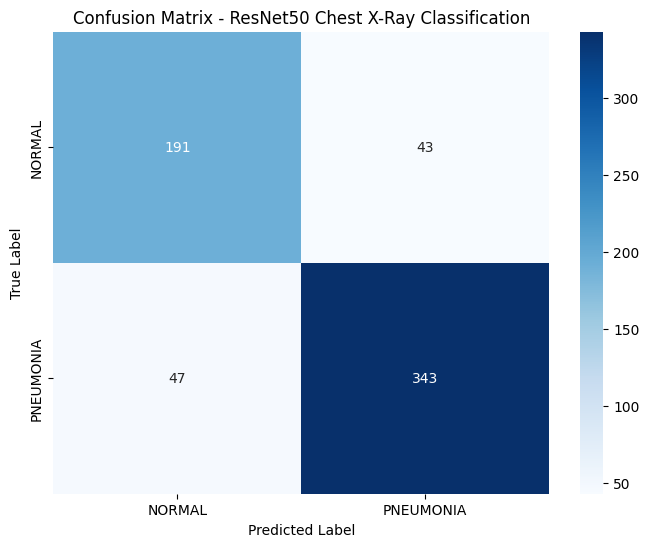


Confusion Matrix:
[[191  43]
 [ 47 343]]


In [11]:
# Generate and display confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Create a figure for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - ResNet50 Chest X-Ray Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print confusion matrix values
print("\nConfusion Matrix:")
print(cm)


20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step


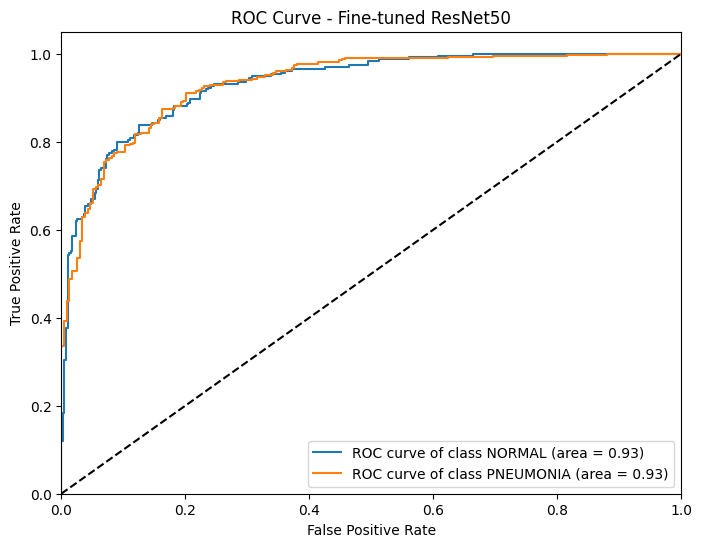

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get predictions and probabilities from the Keras model
test_predictions = model_resnet50.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Get true labels
test_true_classes = test_generator.classes

# Use the predictions as probabilities (they are already softmax outputs)
all_probs = test_predictions
all_labels = test_true_classes

n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fine-tuned ResNet50')
plt.legend(loc='lower right')
plt.show()